### HALO SAMPLING IN 21cmFAST
This short notebook will run through a few quick examples to show how the halo sampler works. We Will:
- draw halo samples from a density grid, and make sure they match the underlying mass function
- draw halo samples from a descendant catalogue, making sure they match both the expected unconditional mass function and respond to any deviations in the descendant catalogue
- create HII boxes and lightcones using these sources, seeing the effect of halo samples on reionization and cosmic dawn

When the HALO_STOCHASTICITY flag option is used, there are a few differences in the running of a lightcone or coeval box.
- At the lowest desired redshift, a limited version of the old halo finder runs the excursion set algorithm to find halos above the mass of the low-resolution grid cell (HII_DIM)
- Below this mass, and above some user-defined value (``UserParams.SAMPLER_MIN_MASS``), we sample the conditional mass function in each grid cell to generate a population of halos, and sample their stellar mass and SFR from lognormal distributions
- The algorithm then steps backward in time, sampling progenitors using each descendant halo as the condition in the conditional mass function. This repeats until we have the halo catalogs at every timestep we wish to compute the reionization history for.
- When the algorithm steps forward in time to calculate ionization histories and spin temperatures, the halo catalogues at the desired redshifts are gridded, and if necessary we add the mean contribution of halos below the sampled mass to each grid cell (by simply integrating the CMF in that cell up to the sampled mass). These halo boxes contain the halo mass density, stellar mass density and star formation rate density which are directly used instead of the overdensity field when calculating the radiative backgrounds.

#### We import a few packages here for plotting and verification

In [1]:
import numpy as np
from matplotlib import cm, gridspec
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.lines import Line2D

import py21cmfast as p21c
from py21cmfast import cache_tools, plotting
from py21cmfast.c_21cmfast import ffi, lib

plt.rcParams["figure.figsize"] = [16, 8]

from copy import deepcopy
from datetime import timedelta
from timeit import default_timer as timer

from hmf import MassFunction
from hmf.halos import MassDefinition
from hmf.mass_function import PS, FittingFunction
from powerbox import get_power

/home/jdavies/.conda/envs/21cmfast/lib/python3.9/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/home/jdavies/.conda/envs/21cmfast/lib/python3.9/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


#### For this exercise, we get reference mass functions from the [HMF package](https://github.com/halomod/hmf)

In [ ]:
# We are using a relatively small box for this test
cosmo_params = p21c.CosmoParams()
user_params = p21c.UserParams(
    HII_DIM=50,
    BOX_LEN=100,
    DIM=200,
    USE_INTERPOLATION_TABLES=True,
    N_THREADS=1,
    HMF=0,
    HII_FILTER="spherical-tophat",
)
astro_params = p21c.AstroParams()
# To use the halo catalogues, we activate USE_HALO_FIELD
# To use the sampler (as opposed to the excursion set halo finder) we activate HALO_STOCHASTICITY
flag_options = p21c.FlagOptions(
    USE_HALO_FIELD=True, HALO_STOCHASTICITY=True, USE_MASS_DEPENDENT_ZETA=True
)

redshift = 8
redshift_update = 10
edges = np.logspace(7, 13, num=64)
widths = np.diff(edges)
dlnm = np.log(edges[1:]) - np.log(edges[:-1])
centres = (edges[:-1] * np.exp(dlnm / 2)).astype("f4")
volume = user_params.BOX_LEN**3
little_h = cosmo_params.cosmo.H0.to("km s-1 Mpc-1") / 100
random_seed = 24

mf_pkg_ps = MassFunction(
    z=redshift,
    Mmin=7,
    Mmax=15,
    cosmo_model=cosmo_params.cosmo,
    hmf_model="PS",
    transfer_model="EH",
)
mf_pkg_ps2 = MassFunction(
    z=redshift_update,
    Mmin=7,
    Mmax=15,
    cosmo_model=cosmo_params.cosmo,
    hmf_model="PS",
    transfer_model="EH",
)

In [3]:
# create the initial conditions
init_box = p21c.initial_conditions(
    user_params=user_params, cosmo_params=cosmo_params, random_seed=random_seed
)

#### First, Run a single halo catalogue from the density grid and plot the resulting binned mass function

In [4]:
halolist_init = p21c.determine_halo_list(
    redshift=redshift,
    init_boxes=init_box,
    user_params=user_params,
    cosmo_params=cosmo_params,
    astro_params=astro_params,
    flag_options=flag_options,
    random_seed=random_seed,
)

/home/jdavies/.conda/envs/21cmfast/lib/python3.9/site-packages/py21cmfast/wrapper.py:1084: UserWarning: DexM Halofinder Uses a fit to the Sheth-Tormen mass function.With HMF!=1 the Halos from DexM will not be from the same mass function
  warnings.warn(


findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found

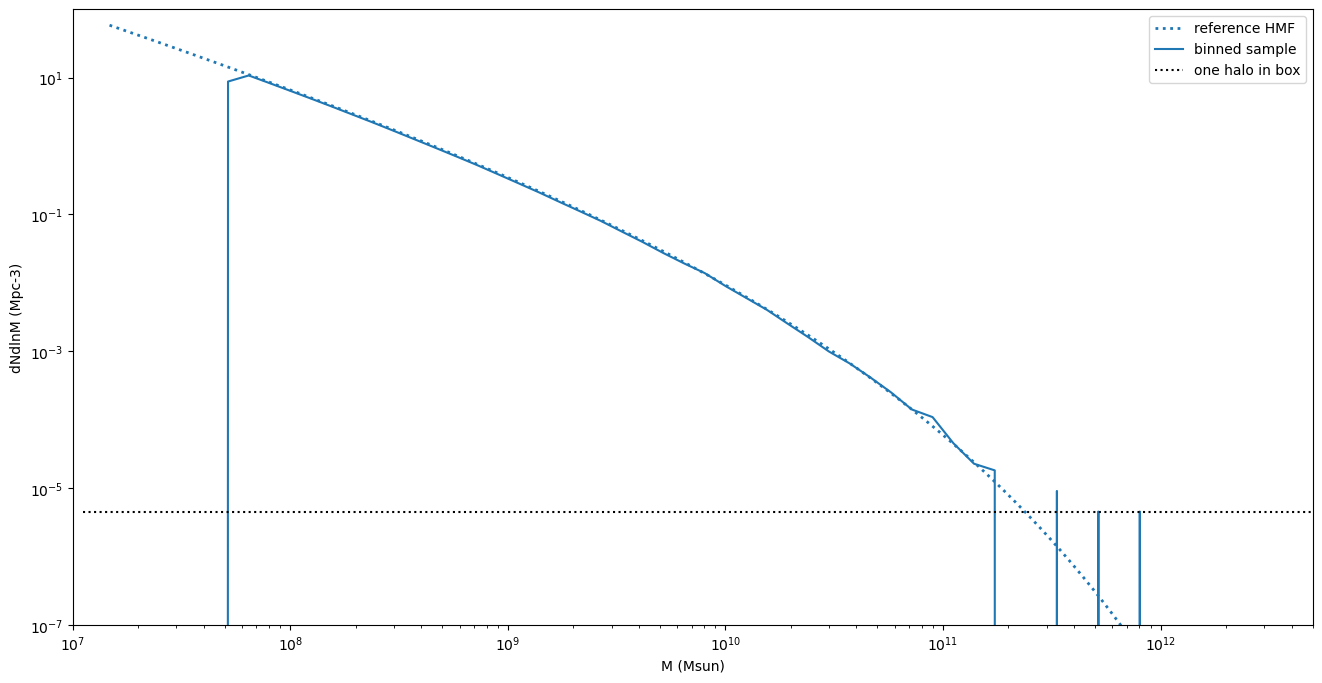

In [5]:
# get the mass function
masses = halolist_init.halo_masses
hist, _ = np.histogram(masses, edges)
mf = hist / volume / dlnm
plt.loglog(
    mf_pkg_ps.m / little_h,
    mf_pkg_ps.dndlnm * (little_h**3),
    color="C0",
    linewidth=2,
    linestyle=":",
    label="reference HMF",
)
plt.loglog(centres, mf, color="C0", label="binned sample")
plt.loglog(centres, 1 / volume / dlnm, "k:", label="one halo in box")

plt.xlim([1e7, 5e12])
plt.ylim([1e-7, 1e2])
plt.ylabel("dNdlnM (Mpc-3)")
plt.xlabel("M (Msun)")
plt.legend()
plt.show()

##### Aside from very high mass halos (This is the excursion set model acting above the cell mass) Samples follow the expected mass function very closely

#### We can also sample from a previously calculated (descendant) halo list by specifying a new redshift

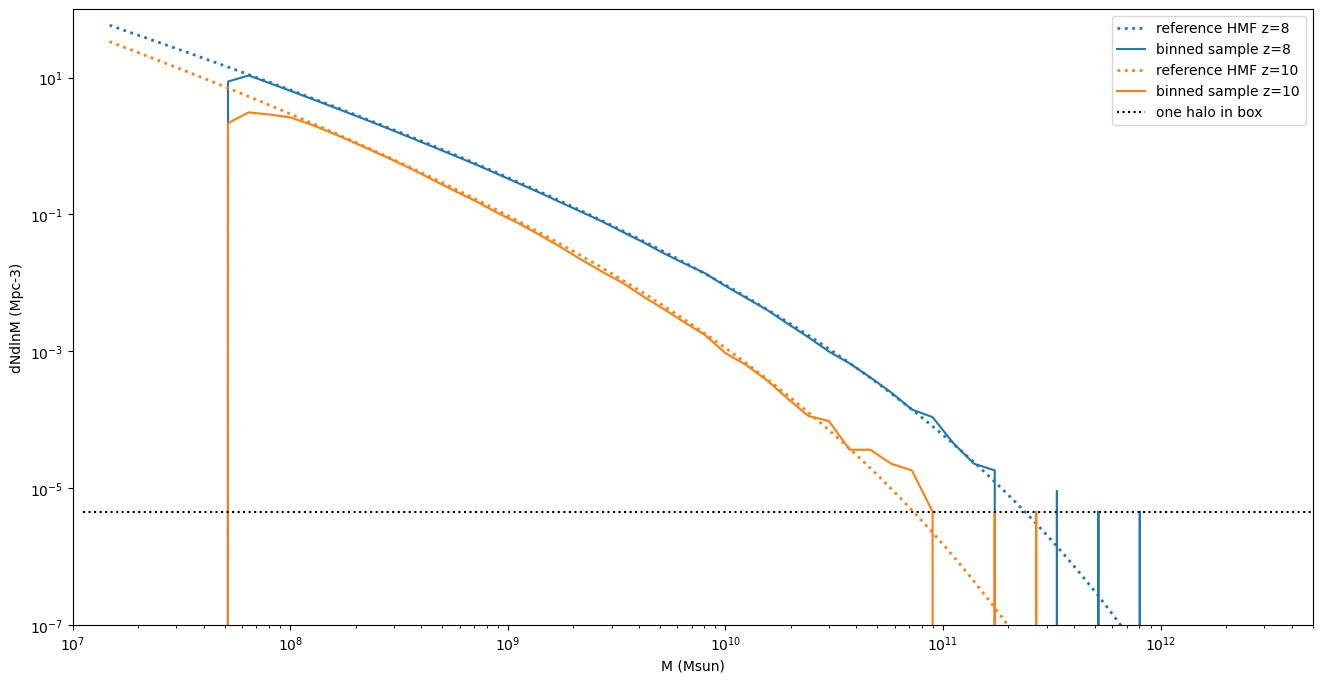

In [6]:
halolist_next = p21c.determine_halo_list(
    redshift=redshift_update, init_boxes=init_box, halos_desc=halolist_init
)
# get the mass function
masses = halolist_next.halo_masses
hist, _ = np.histogram(masses, edges)
mf2 = hist / volume / dlnm
plt.loglog(
    mf_pkg_ps.m / little_h,
    mf_pkg_ps.dndlnm * (little_h**3),
    color="C0",
    linewidth=2,
    linestyle=":",
    label=f"reference HMF z={redshift}",
)
plt.loglog(centres, mf, color="C0", label=f"binned sample z={redshift}")

plt.loglog(
    mf_pkg_ps2.m / little_h,
    mf_pkg_ps2.dndlnm * (little_h**3),
    color="C1",
    linewidth=2,
    linestyle=":",
    label=f"reference HMF z={redshift_update}",
)
plt.loglog(centres, mf2, color="C1", label=f"binned sample z={redshift_update}")
plt.loglog(centres, 1 / volume / dlnm, "k:", label="one halo in box")

plt.xlim([1e7, 5e12])
plt.ylim([1e-7, 1e2])
plt.ylabel("dNdlnM (Mpc-3)")
plt.xlabel("M (Msun)")
plt.legend()
plt.show()

##### Results for the next redshift follow the mass function at z=10, even through they are not explicitly given this mass function

#### If we modify the descendant halo list, we can see how descendant halos effect the progenitor population
In this case, we add 1000 halos of mass 1e11 to see what happens to the progenitor population

In [7]:
halolist_edit = deepcopy(halolist_init)

# add a bunch of large halos (at 10^11 solar) to the first catalogue
halomass_edit = halolist_edit.halo_masses
halomass_edit[halolist_edit.n_halos : halolist_edit.n_halos + 1000] = 1e11
halolist_edit.halo_masses = halomass_edit
halolist_edit.n_halos = halolist_edit.n_halos + 1000

# call to pass memory to c
halolist_edit()

# the redshift difference is just a hack so it doesn't read the cache, this shouldn't effect the results
halolist_next2 = p21c.determine_halo_list(
    redshift=redshift_update * 1.001,
    halos_desc=halolist_edit,
    init_boxes=init_box,
)

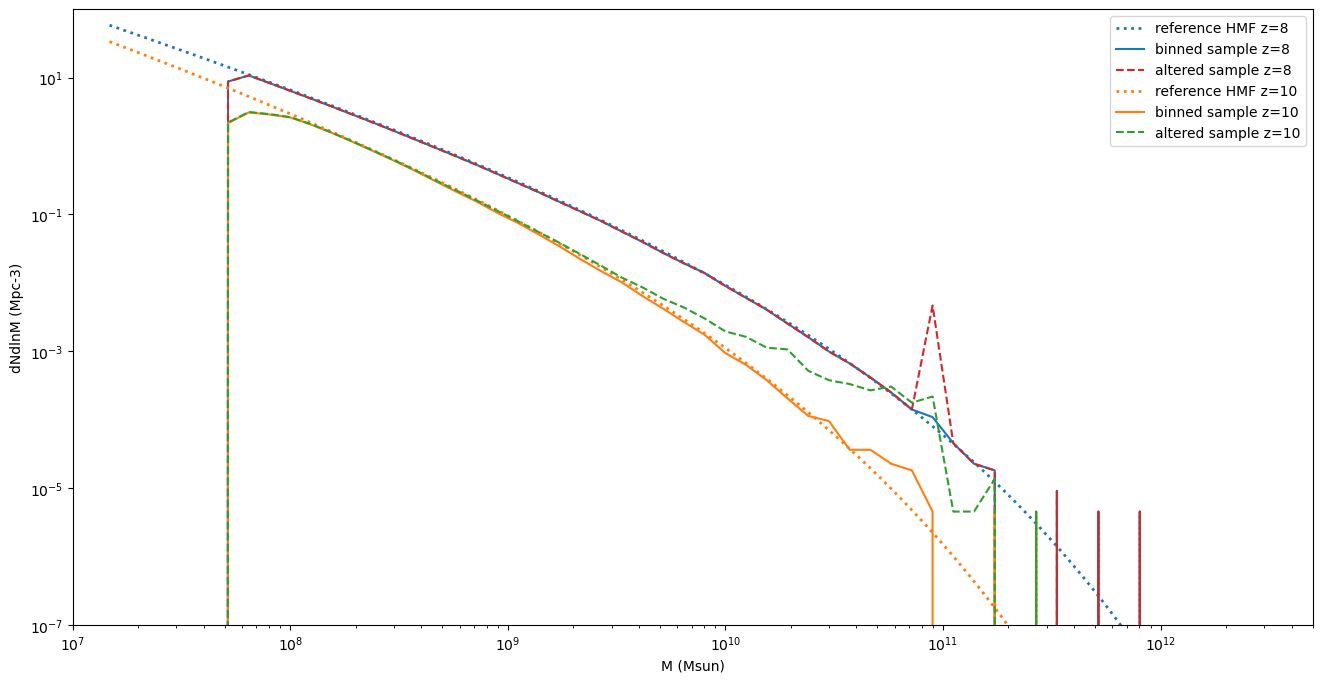

In [8]:
# get the mass functions
masses = halolist_next2.halo_masses
hist, _ = np.histogram(masses, edges)
mf3 = hist / volume / dlnm

masses = halolist_edit.halo_masses
hist, _ = np.histogram(masses, edges)
mf4 = hist / volume / dlnm

plt.loglog(
    mf_pkg_ps.m / little_h,
    mf_pkg_ps.dndlnm * (little_h**3),
    color="C0",
    linewidth=2,
    linestyle=":",
    label=f"reference HMF z={redshift}",
)

plt.loglog(centres, mf, color="C0", label=f"binned sample z={redshift}")
plt.loglog(
    centres, mf4, color="C3", linestyle="--", label=f"altered sample z={redshift}"
)


plt.loglog(
    mf_pkg_ps2.m / little_h,
    mf_pkg_ps2.dndlnm * (little_h**3),
    color="C1",
    linewidth=2,
    linestyle=":",
    label=f"reference HMF z={redshift_update}",
)
plt.loglog(centres, mf2, color="C1", label=f"binned sample z={redshift_update}")

plt.loglog(
    centres,
    mf3,
    color="C2",
    linestyle="--",
    label=f"altered sample z={redshift_update}",
)

plt.xlim([1e7, 5e12])
plt.ylim([1e-7, 1e2])
plt.ylabel("dNdlnM (Mpc-3)")
plt.xlabel("M (Msun)")
plt.legend()
plt.show()

##### The alteration in the descendant catalogue (red dashed line) is reflected in its progenitors (green dashed line)
We see an increase in higher mass halos just underneath the added descendant mass of 1e11

#### HALO CATALOGUES CAN BE PERTURBED AND GRIDDED
- When we perturb the halo list, it moves from the Lagrangian initial condition coordinates onto the Eulerian coordinates at the desired redshift
- the HaloBox class stores the gridded quantities (halo mass, stellar mass, star formation rate) of the halo catalogues, which are used for calculating the radiative backgrounds

In [9]:
# This function moves the halos from the initial condition grid onto the real grid at the given redshift
pt_halos = p21c.perturb_halo_list(
    redshift=redshift, halo_field=halolist_init, init_boxes=init_box
)

In [10]:
# This function sums halo proprties within each cell to create grids of halo mass, stellar mass, star formation rate and more
halo_box = p21c.halo_box(redshift=redshift, pt_halos=pt_halos, init_boxes=init_box)

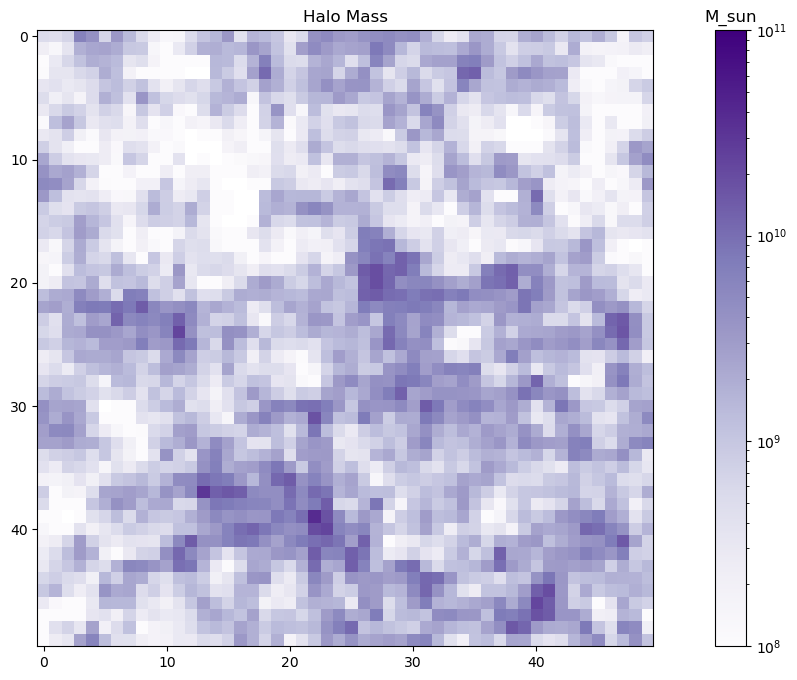

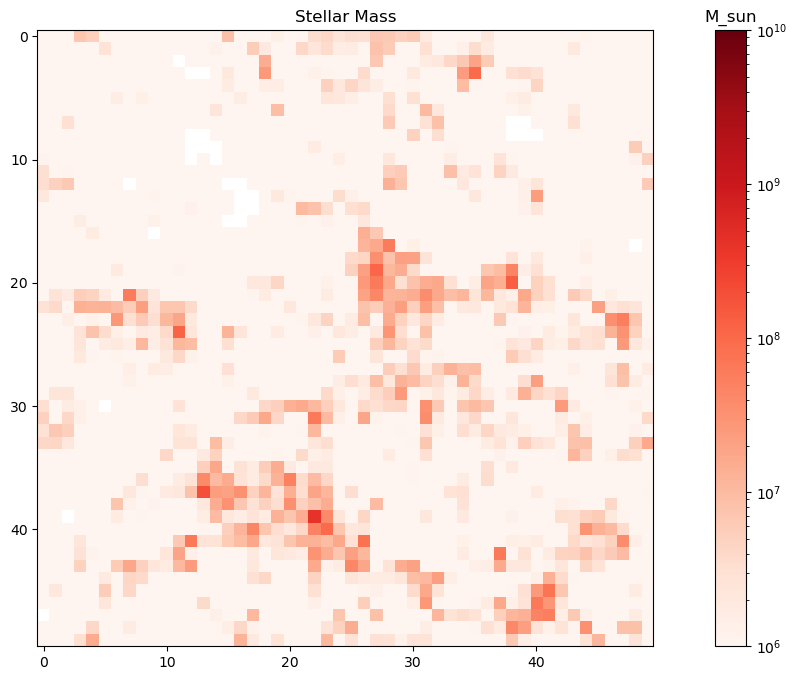

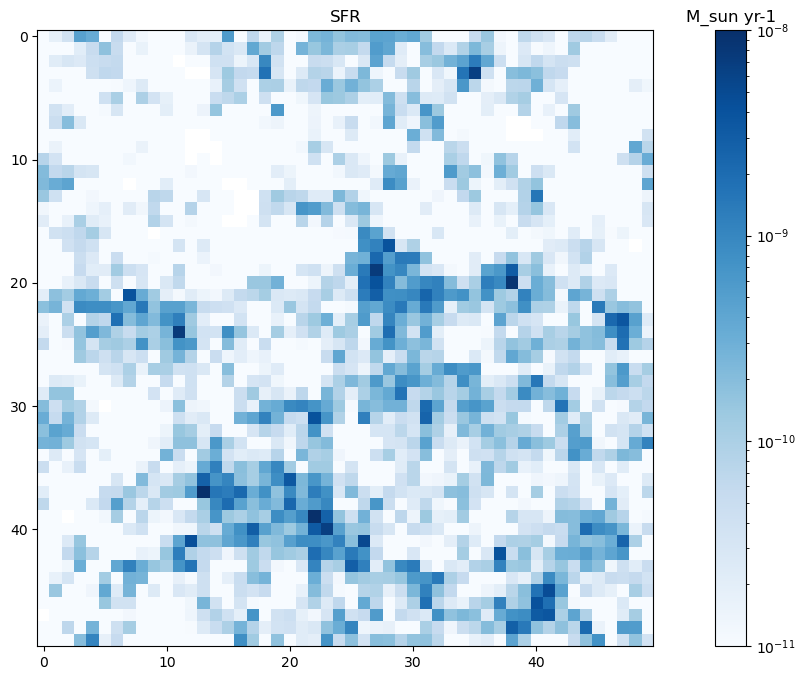

In [11]:
plt.figure()
plt.imshow(
    halo_box.halo_mass[..., 0], cmap=cm.Purples, norm=LogNorm(vmin=1e8, vmax=1e11)
)
plt.title("Halo Mass")
cb = plt.colorbar()
cb.ax.set_title("M_sun")
plt.show()
plt.imshow(halo_box.halo_stars[..., 0], cmap=cm.Reds, norm=LogNorm(vmin=1e6, vmax=1e10))
plt.title("Stellar Mass")
cb = plt.colorbar()
cb.ax.set_title("M_sun")
plt.show()
plt.imshow(
    halo_box.halo_sfr[..., 0], cmap=cm.Blues, norm=LogNorm(vmin=1e-11, vmax=1e-8)
)
plt.title("SFR")
cb = plt.colorbar()
cb.ax.set_title("M_sun yr-1")
plt.show()

We expect halo mass, stellar mass and SFR to follow a very similar distribution, as all are dependent on the density field

#### These grids can be used instead of the density field when calculating HII maps or spin temperatures

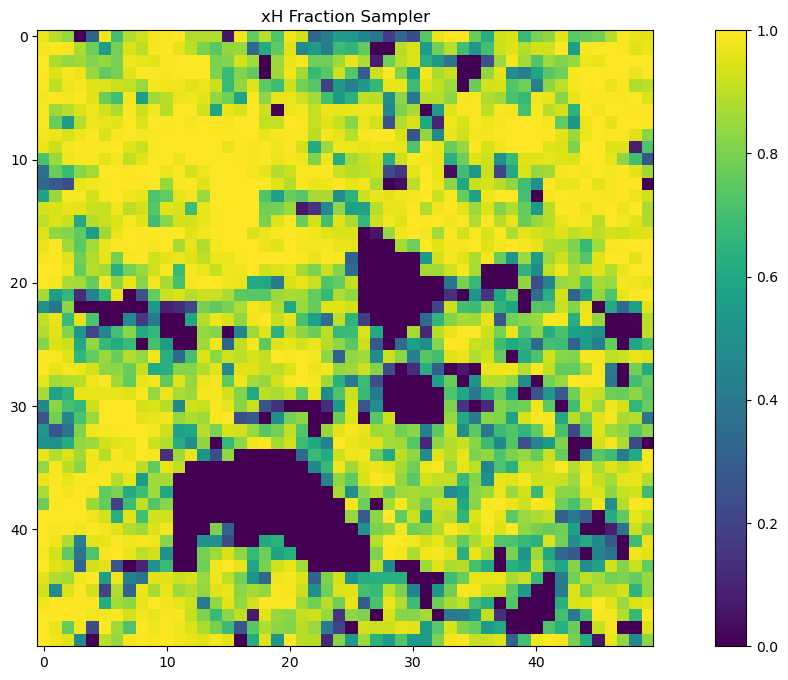

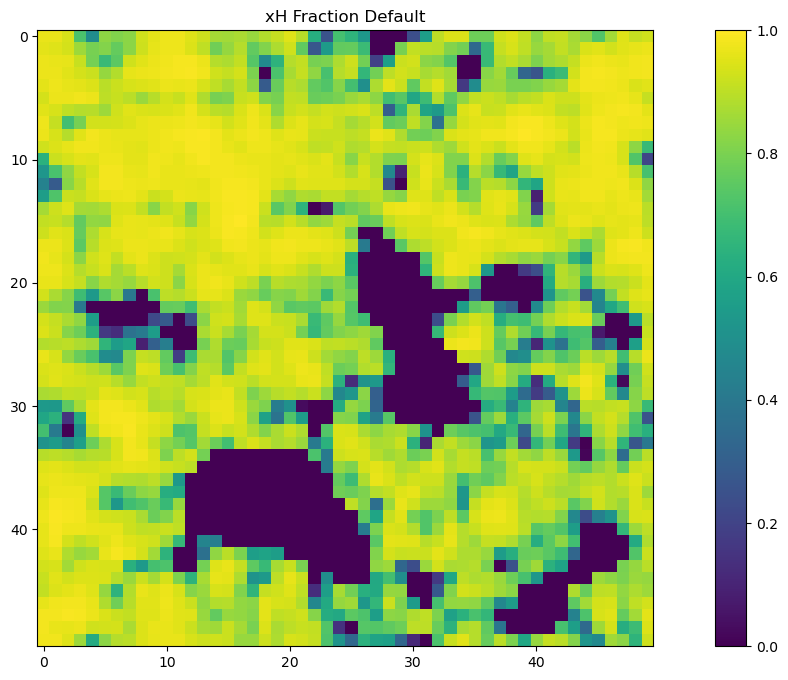

In [12]:
# passing a halo box into this function (with the USE_HALO_FIELD flag) will
# use the gridded halos instead of the density field to determine ionizing radiation
ionbox = p21c.ionize_box(halobox=halo_box)

# now we run without halos to compare
flag_options_nosampler = deepcopy(flag_options)
flag_options_nosampler.update(USE_HALO_FIELD=False, HALO_STOCHASTICITY=False)
ionbox_nosampler = p21c.ionize_box(
    redshift=redshift,
    cosmo_params=cosmo_params,
    user_params=user_params,
    astro_params=astro_params,
    flag_options=flag_options_nosampler,
)

plt.figure()
plt.imshow(ionbox.xH_box[..., 0], cmap=cm.viridis, norm=Normalize(vmin=0, vmax=1))
plt.title("xH Fraction Sampler")
plt.colorbar()
plt.show()
plt.imshow(
    ionbox_nosampler.xH_box[..., 0], cmap=cm.viridis, norm=Normalize(vmin=0, vmax=1)
)
plt.title("xH Fraction Default")
plt.colorbar()
plt.show()

The ionisation field is much noisier on small scales due to much larger variation in stellar mass. but follows the same distribution

#### Full lightcone run with / without halo sampling

In [ ]:
flag_options.update(USE_TS_FLUCT=True)
lightcone_quantities = ["density", "xH_box", "brightness_temp"]
lc = p21c.run_lightcone(
    redshift=6,
    max_redshift=30,
    flag_options=flag_options,
    astro_params=astro_params,
    user_params=user_params,
    cosmo_params=cosmo_params,
    lightcone_quantities=lightcone_quantities,
    global_quantities=lightcone_quantities,
    random_seed=random_seed,
)

flag_options_nosampler.update(USE_TS_FLUCT=True)
lc_nosampler = p21c.run_lightcone(
    redshift=6,
    max_redshift=30,
    flag_options=flag_options_nosampler,
    astro_params=astro_params,
    user_params=user_params,
    cosmo_params=cosmo_params,
    lightcone_quantities=lightcone_quantities,
    global_quantities=lightcone_quantities,
    random_seed=random_seed,
)

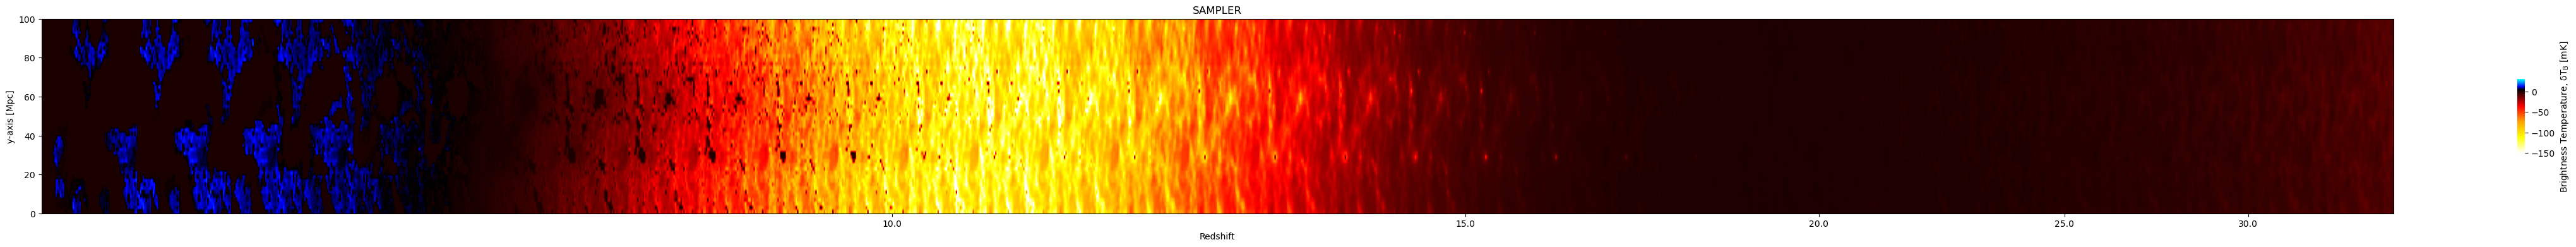

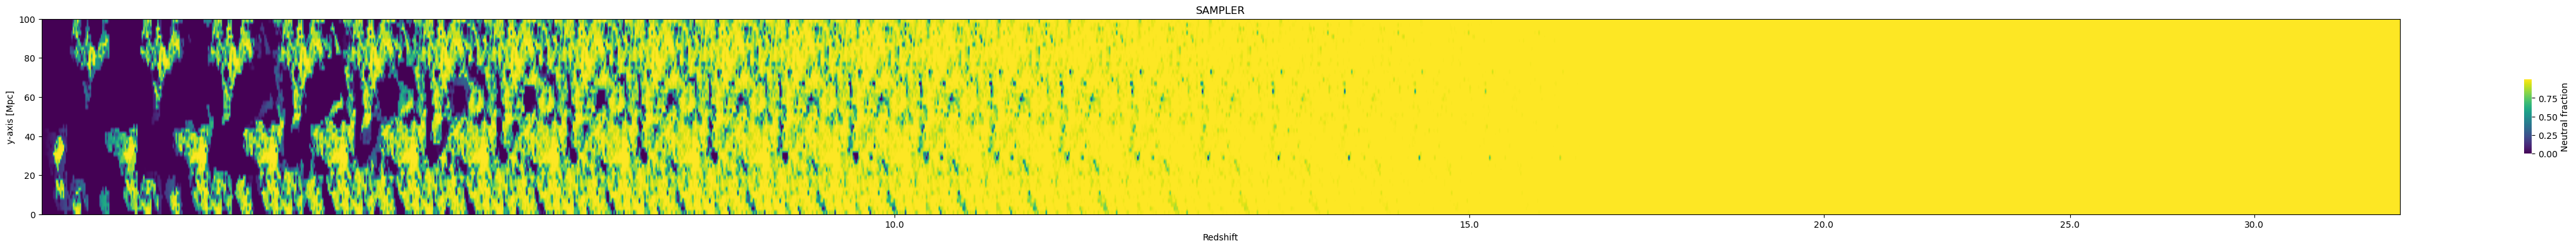

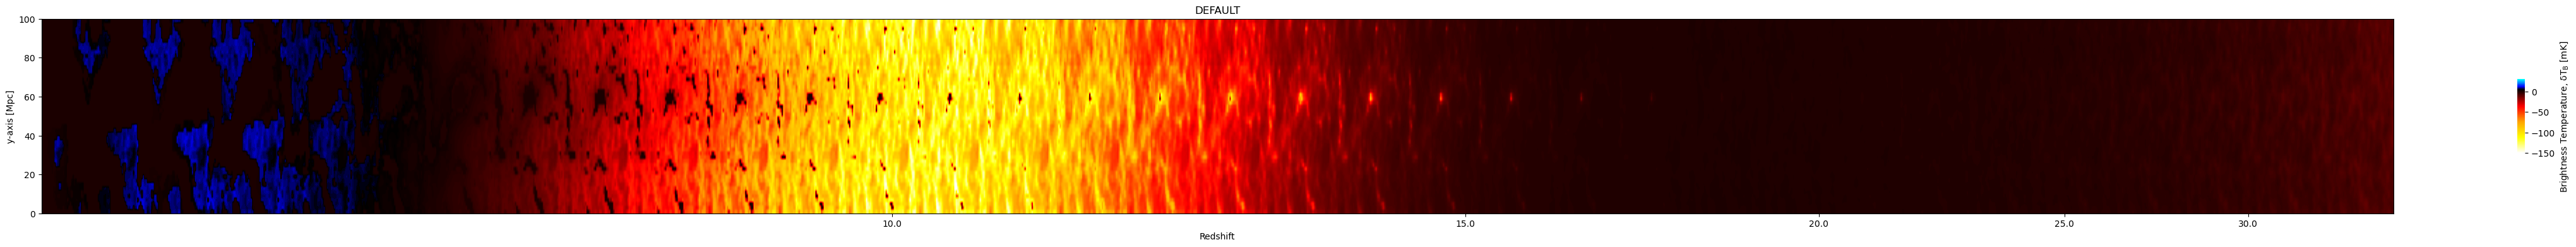

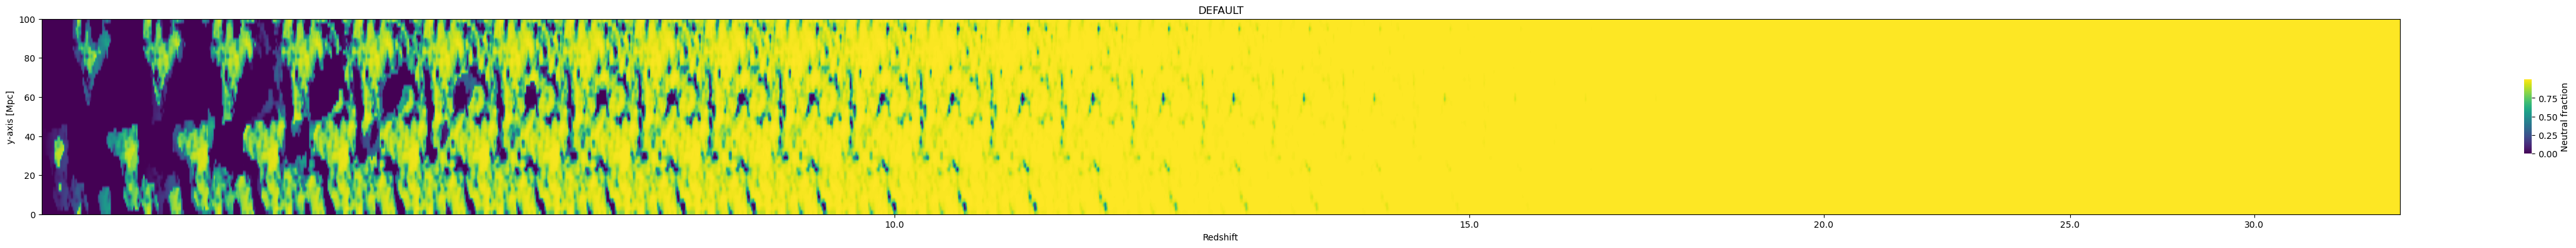

In [23]:
for l, title in zip([lc, lc_nosampler], ["SAMPLER", "DEFAULT"], strict=False):
    for k in ["brightness_temp", "xH_box"]:
        plot_shape = l.shape[::-1]
        fig, ax = plt.subplots(
            1,
            1,
            figsize=(
                plot_shape[0] * 0.03 + 0.5,
                plot_shape[1] * 0.06 + 1.0,
            ),
        )

        p21c.plotting.lightcone_sliceplot(
            l,
            kind=k,
            zticks="redshift",
            aspect="auto",
            fig=fig,
            ax=ax,
            log=False,
            vertical=False,
            cbar_horizontal=False,
            slice_index=24,
        )
        ax.set_title(title)
        plt.show()

#### Examining the global brightness temperature and neutral fraction
The global results should be very similar, However differences can occur due to the varying occurrence of rare objects at high redshift, especially at smaller box sizes. It should also be noted that the mean fixing (in both ionizing emissivity and star formation rate density) which occurs in default 21cmFAST is not possible with the halo model, since it would cause the radiative source terms to be incompatible with the halo catalogs

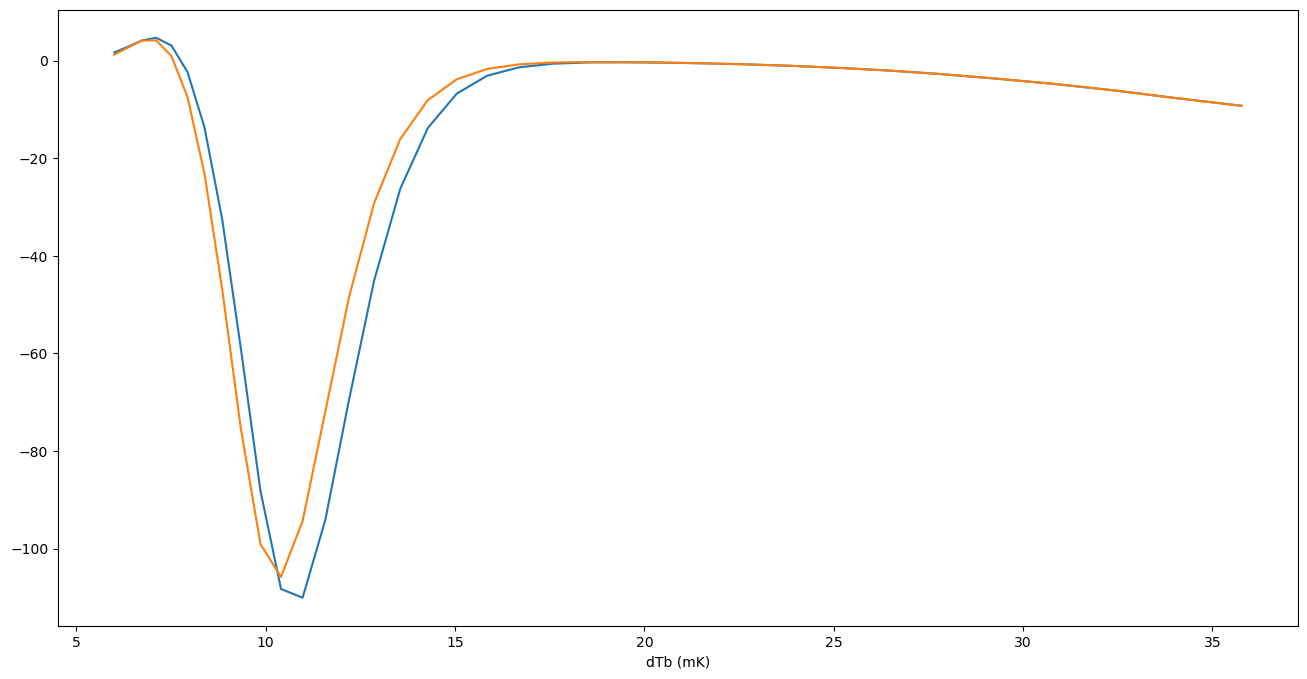

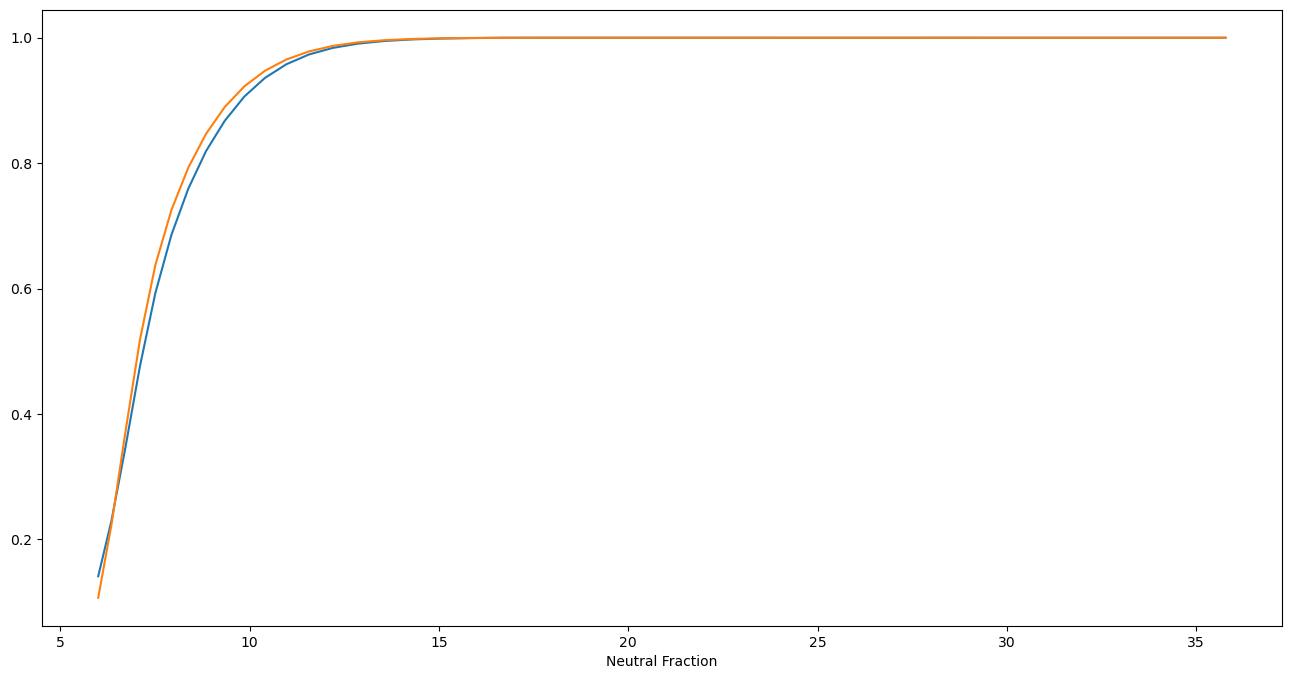

In [15]:
plt.figure()
plt.plot(lc.node_redshifts, lc.global_brightness_temp)
plt.plot(lc_nosampler.node_redshifts, lc_nosampler.global_brightness_temp)
plt.xlabel("redshift")
plt.xlabel("dTb (mK)")
plt.show()

plt.figure()
plt.plot(lc.node_redshifts, lc.global_xH)
plt.plot(lc_nosampler.node_redshifts, lc_nosampler.global_xH)
plt.xlabel("redshift")
plt.xlabel("Neutral Fraction")
plt.show()

#### Examining the 1D power spectra around z=12
We should see an increase variation, especially at small scales due to the shot-noise induced by halo fluctuations

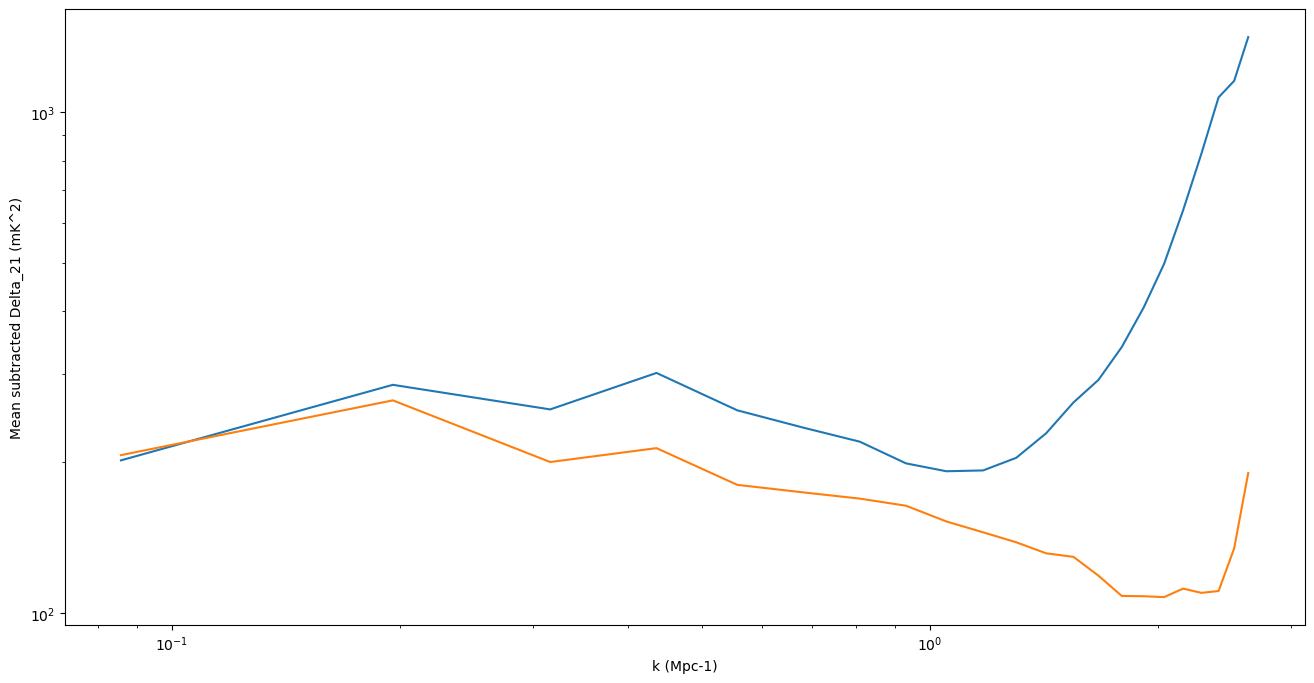

In [16]:
z_plot = 12
z_idx = np.argmin(np.fabs(lc.lightcone_redshifts - z_plot))
box_len = lc.user_params.BOX_LEN
grid_dim = lc.user_params.HII_DIM

# select the chunk we want to make the power spectrum from
lc_chunk = lc.brightness_temp[
    ..., z_idx - int(grid_dim / 2) : z_idx + int(grid_dim / 2)
]

# subtract the means in each slice
lc_chunk = lc_chunk - lc_chunk.mean(axis=(0, 1))[None, None, :]
chunk_dim = np.array(lc_chunk.shape) * box_len / grid_dim

# get the power using powerbox
p, k = get_power(lc_chunk, boxlength=chunk_dim)

lc_chunk_nosampler = lc_nosampler.brightness_temp[
    ..., z_idx - int(grid_dim / 2) : z_idx + int(grid_dim / 2)
]
lc_chunk_nosampler = (
    lc_chunk_nosampler - lc_chunk_nosampler.mean(axis=(0, 1))[None, None, :]
)
p2, k2 = get_power(lc_chunk_nosampler, boxlength=chunk_dim)

plt.figure()
plt.loglog(k, p * k**3 / (np.pi * 2))
plt.loglog(k2, p2 * k2**3 / (np.pi * 2))
plt.xlabel("k (Mpc-1)")
plt.ylabel("Mean subtracted Delta_21 (mK^2)")
plt.show()